In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Layer
import keras_cv

2024-05-07 18:02:33.995532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 18:02:33.995669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 18:02:34.153375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Train Data 

In [2]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape)
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


# Create Non-Overlapping EEG Id

In [3]:
train = df.groupby('eeg_id')[['spectrogram_id']].agg({'spectrogram_id':'first'})
train.columns = ['spec_id']

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape)
train.head()

Train non-overlapp eeg_id shape: (17089, 10)


,eeg_id,spec_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Train Scheduler

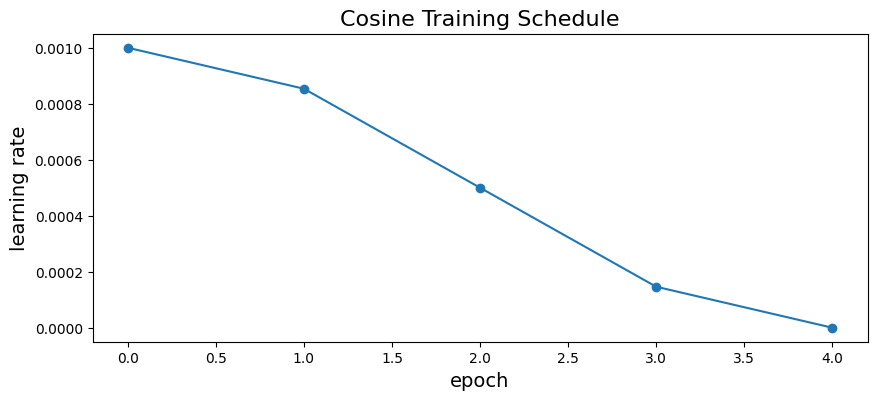

In [4]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS2 = 5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS2)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Handling Montages

In [5]:
NAMES = ['LL', 'LP', 'RL', 'RP', 'C']

IMP_FEATS = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3',
             'T5','O1', 'Fp2', 'F4', 'C4', 'P4',
             'F8', 'T4', 'T6', 'O2', 'Fz', 'Cz', 'Pz']

IMP_FEATS_index = {y:x for x,y in enumerate(IMP_FEATS)}

BANANA = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

CENTER = ['Fz', 'Cz', 'Pz']

# Data Loader

The Data loader outputs 18 feature signal from the BANANA Montage (16) and from the CENTER Montage (2),  each of 10000 sample representing the middle 50 seconds of the given signals. No augmentation is used here.

In [6]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}
file_path = '/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/'
class DataGenerator(tf.keras.utils.Sequence):
    'Generate data for keras'
    def __init__(self, data, batch_size = 32, shuffle = False, mode='train', IMP_FEATS = IMP_FEATS ,
                 file_path = file_path, BANANA = BANANA, CENTER = CENTER):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.mode = mode
        self.BANANA = BANANA
        self.CENTER = CENTER
        self.IMP_FEATS = IMP_FEATS
        if isinstance(file_path, str):
            self.file_path = file_path
        else: print('file_path must be a path to the training file signals in parquet format')
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int(np.ceil(len(self.data) / self.batch_size))
        return ct

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True: np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X1, y = self.__data_generation(indexes)
        return X1, y


    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        X1 = np.zeros((len(indexes), 10000, 18, 1), dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')

        for j,i in enumerate(indexes):

            row = self.data.iloc[i]
            eeg = pd.read_parquet(f'{self.file_path}{row.eeg_id}.parquet', columns = self.IMP_FEATS)
            middle = (len(eeg)-10_000)//2
            eeg = eeg.iloc[middle:middle+10_000]
            count = 0
            # Calculate BANANA Features
            for k in range(4):
                COLS = self.BANANA[k]
                coeff = []
                for kk in range(4):
                    
                    # Calculate the differences
                    x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values
                    
                    # Standardize
                    x = np.clip(x, -1024, 1024)
                    x = np.nan_to_num(x, nan = 0) / 32.0
                    
                    # Add dimension to make it compatible with cwt layer input
                    X1[j,:,k + kk + count, :] = np.expand_dims(x, axis = -1)
                    
                count += 3
            # Calculate CENTER Features
            for m in range(2):
                z = eeg[self.CENTER[m]].values - eeg[self.CENTER[m + 1]].values
                
                z = np.clip(z, -1024, 1024)
                z = np.nan_to_num(z, nan = 0) / 32.0
                
                X1[j,:,-1 - m, :] = np.expand_dims(z, axis = -1)
                
            if self.mode != 'test':
                y[j,] = row[TARGETS]

        return X1, y

# Display Data Loader

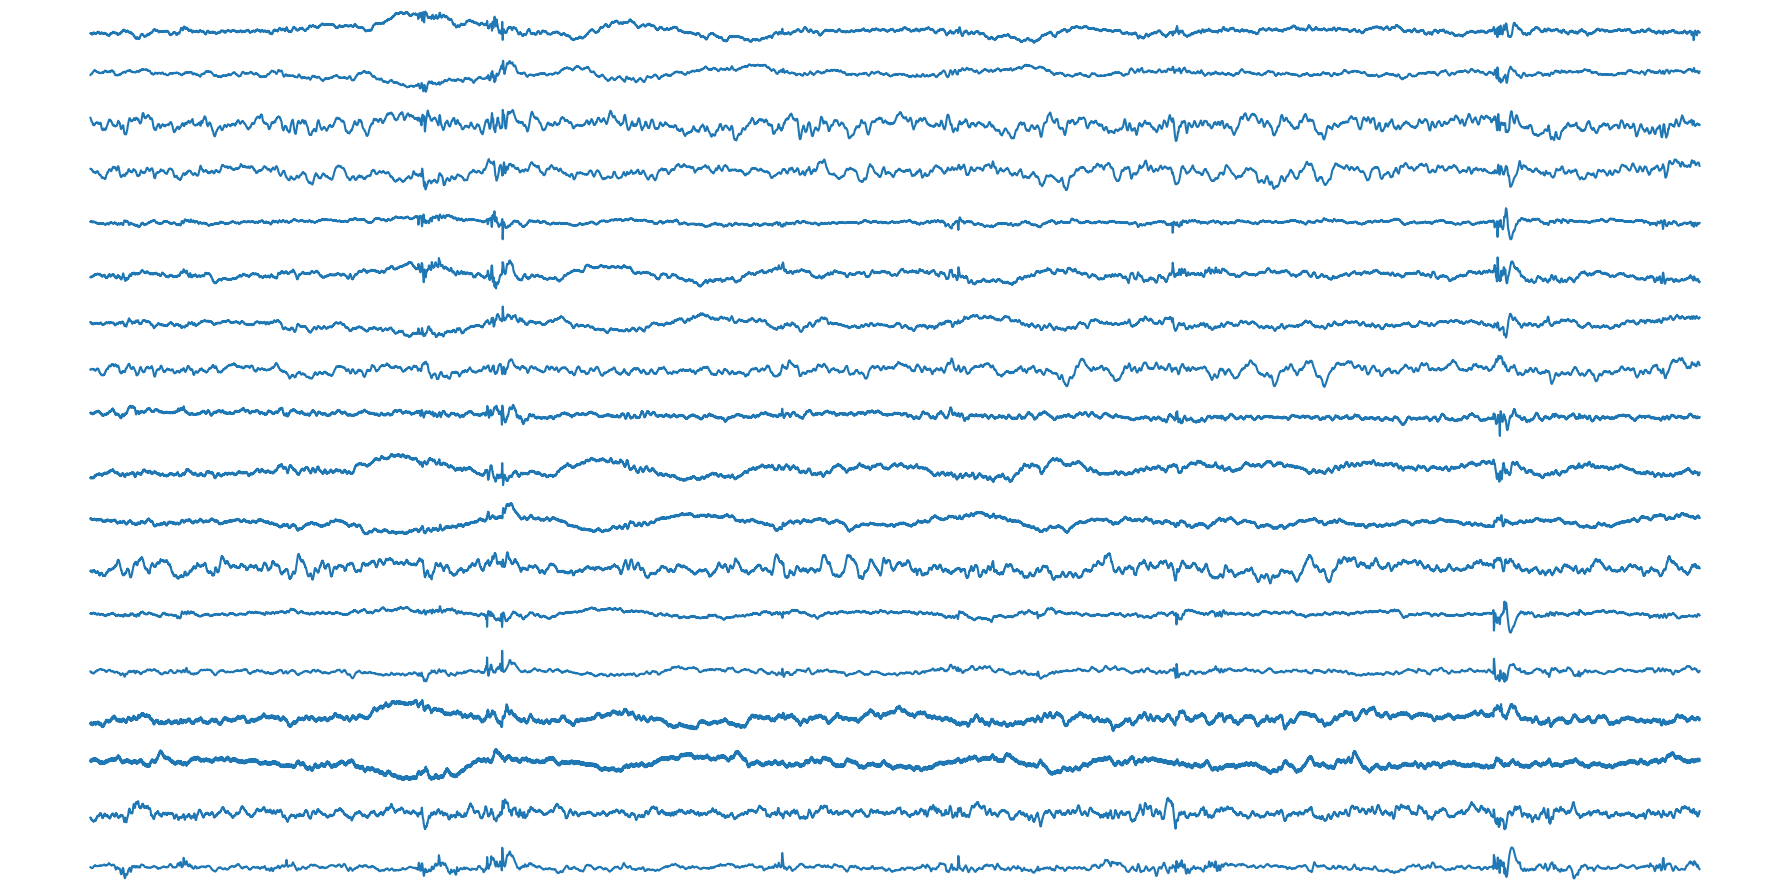

In [7]:
gen = DataGenerator(train, batch_size = 32, shuffle = False)
x1, y =gen[0] # Take one batch
fig, ax = plt.subplots(18, 1, figsize=(18,9))
for i in range(x1[0].shape[1]): # Take one sample
    ax[i].plot(x1[0][:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# CWT Layer

Layer to compute the Complex Wavelet Transform of the signal  

In [8]:
%cd /kaggle/input/cmorlet-tensorflow-3/cmorlet-tensorflow-3/CWT

/kaggle/input/cmorlet-tensorflow-3/cmorlet-tensorflow-3/CWT


In [9]:
import cwt

# Magnitude Layer

In [10]:
@keras.saving.register_keras_serializable()
class Magnitude_of_Complex_CWT(Layer):

    """
    Custom Keras layer to compute the magnitude of complex Wavelet Transform scalograms.
    """
    def __init__(self, magnitude = True, **kwargs):
        super().__init__(**kwargs)
        self.magnitude = magnitude
        
    def call(self, inputs):
        if self.magnitude:
            real_part = inputs[:, :, :, 0]
            imag_part = inputs[:, :, :, 1]
            result = tf.math.sqrt(tf.math.square(real_part) + tf.math.square(imag_part))
            result = tf.expand_dims(result, axis=-1)
            return result
        else:
            print("Layer is not activated!")
            
    def get_config(self):
        return {"magnitude": self.magnitude}

# Scale Layer

In [11]:
@keras.saving.register_keras_serializable()
class scale_to_255(Layer):
    """
    Layer to Normalize the Image between values 0 and 255 to be fed to efficientnet model
    """
    def __init__(self, scale = True, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, x):
        if self.scale:
            min_val = tf.reduce_min(x)
            max_val = tf.reduce_max(x)
            return 255.0 * (x - min_val) / (max_val - min_val + 1e-7)
        else:
            print("layer is not acitvated!")
            
    def get_config(self):
        return {"scale": self.scale}

# Initialize the 3 custom Layers for Training

## cwt

In [12]:
cwt_layer = cwt.ComplexMorletCWT(
    wavelet_width=7, 
    fs=200,         
    stride=16,
    border_crop=1,
    lower_freq=0.5,     
    upper_freq=40,      
    n_scales=40,       
    trainable=False    
)

## Scale and Magnitude

In [13]:
# Initialize Instance for Magnitude_of_Complex_CWT Layer
mos = Magnitude_of_Complex_CWT()
# Initialize Instance for scale_to_255 Layer
scale = scale_to_255()

# Building the model

In [14]:
eff_net_model = keras_cv.models.ImageClassifier.from_preset("efficientnetv2_b2_imagenet", num_classes = 6)

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


In [15]:
def build_model_MK():
    # Addiding the Last Dimension for compatibility with cwt_layer input shape which represent the channel axis
    inp = tf.keras.Input(shape = (10000, 18, 1))
    
    scalogram_0 = cwt_layer(inp[:,:,0])
    scalogram_0 = mos(scalogram_0)
    scalogram_1 = cwt_layer(inp[:,:,1])
    scalogram_1 = mos(scalogram_1)
    scalogram_2 = cwt_layer(inp[:,:,2])
    scalogram_2 = mos(scalogram_2)
    scalogram_3 = cwt_layer(inp[:,:,3])
    scalogram_3 = mos(scalogram_3)
    scalogram_4 = cwt_layer(inp[:,:,4])
    scalogram_4 = mos(scalogram_4)
    scalogram_5 = cwt_layer(inp[:,:,5])
    scalogram_5 = mos(scalogram_5)
    scalogram_6 = cwt_layer(inp[:,:,6])
    scalogram_6 = mos(scalogram_6)
    scalogram_7 = cwt_layer(inp[:,:,7])
    scalogram_7 = mos(scalogram_7)
    scalogram_8 = cwt_layer(inp[:,:,8])
    scalogram_8 = mos(scalogram_8)
    scalogram_9 = cwt_layer(inp[:,:,9])
    scalogram_9 = mos(scalogram_9)
    scalogram_10 = cwt_layer(inp[:,:,10])
    scalogram_10 = mos(scalogram_10)
    scalogram_11 = cwt_layer(inp[:,:,11])
    scalogram_11 = mos(scalogram_11)
    scalogram_12 = cwt_layer(inp[:,:,12])
    scalogram_12 = mos(scalogram_12)
    scalogram_13 = cwt_layer(inp[:,:,13])
    scalogram_13 = mos(scalogram_13)
    scalogram_14 = cwt_layer(inp[:,:,14])
    scalogram_14 = mos(scalogram_14)
    scalogram_15 = cwt_layer(inp[:,:,15])
    scalogram_15 = mos(scalogram_15)
    scalogram_16 = cwt_layer(inp[:,:,16])
    scalogram_16 = mos(scalogram_16)
    scalogram_17 = cwt_layer(inp[:,:,17])
    scalogram_17 = mos(scalogram_17)
    x1 = tf.keras.layers.Concatenate(axis = 2)([scalogram_0, scalogram_1,scalogram_2, scalogram_3,
                                              scalogram_4, scalogram_5, scalogram_6, scalogram_7,
                                              scalogram_8, scalogram_9, scalogram_10, scalogram_11,
                                              scalogram_12, scalogram_13, scalogram_14, scalogram_15,
                                               scalogram_16, scalogram_17])
    
    x2 = Permute((2,1,3))(x1)
    x3 = tf.keras.layers.Resizing(height=512, width=512, interpolation='nearest')(x2)
    x4 = scale(x3)
    x5 = tf.keras.layers.Concatenate(axis=3)([x4,x4,x4])
    
    out = eff_net_model(x5)
    
    final_model = Model(inputs = inp, outputs = out)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    loss = tf.keras.losses.KLDivergence()
    final_model.compile(loss=loss, optimizer = opt)
    
    return final_model

# Train the Model

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
import tensorflow.keras.backend as K, gc
from tensorflow.keras.callbacks import ModelCheckpoint

VER = 10
all_oof = []
all_true = []
num_epochs = 5
gkf = GroupKFold(n_splits = 5)



for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(train.iloc[train_index], shuffle = True, batch_size = 32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle = False, batch_size = 64)
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    K.clear_session()
    eff_net_model = keras_cv.models.ImageClassifier.from_preset("efficientnetv2_b2_imagenet", num_classes = 6)
    eff_net = build_model_MK()
    checkpoint_callback = ModelCheckpoint(filepath=f'/kaggle/working/Eff_Net_v{VER}_f{i}.keras', 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      save_weights_only=False, 
                                      mode='min', 
                                      verbose=1)
    eff_net.fit(train_gen, verbose = 1, validation_data = valid_gen, epochs = num_epochs, callbacks=[LR, checkpoint_callback])
    oof = eff_net.predict(valid_gen, verbose = 1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)

    del oof
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)



#########################
### Fold 1
### train size 13671, valid size 3418
#########################


Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715105293.194114     138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715105293.346985     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


152/428 ━━━━━━━━━━━━━━━━━━━━ 4:24 960ms/step - loss: 0.8896

W0000 00:00:1715105536.351650     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7634

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715105859.941311     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715105984.739113     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.61409, saving model to /kaggle/working/Eff_Net_v10_f0.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 893s 2s/step - loss: 0.7632 - val_loss: 0.6141 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008536998372026805.
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - loss: 0.4875
Epoch 2: val_loss improved from 0.61409 to 0.60272, saving model to /kaggle/working/Eff_Net_v10_f0.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - loss: 0.4875 - val_loss: 0.6027 - learning_rate: 8.5370e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005005000000000001.
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - loss: 0.4097
Epoch 3: val_loss did not improve from 0.60272
428/428 ━━━━━━━━━━━━━━━━━━━━ 477s 1s/step - loss: 0.4097 - val_loss: 0.6214 - learning_rate: 5.0050e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00014730016279731955.
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 930ms/step - loss: 

W0000 00:00:1715107843.439087     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step 


W0000 00:00:1715107903.742986     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 2
### train size 13671, valid size 3418
#########################


Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715108046.124722     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 62/428 ━━━━━━━━━━━━━━━━━━━━ 5:46 947ms/step - loss: 1.0373

W0000 00:00:1715108182.814302     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7674

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715108535.395745     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715108587.507804     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.67760, saving model to /kaggle/working/Eff_Net_v10_f1.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - loss: 0.7671 - val_loss: 0.6776 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008536998372026805.
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - loss: 0.4991
Epoch 2: val_loss improved from 0.67760 to 0.56727, saving model to /kaggle/working/Eff_Net_v10_f1.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - loss: 0.4990 - val_loss: 0.5673 - learning_rate: 8.5370e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005005000000000001.
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 933ms/step - loss: 0.4265
Epoch 3: val_loss improved from 0.56727 to 0.56166, saving model to /kaggle/working/Eff_Net_v10_f1.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - loss: 0.4265 - val_loss: 0.5617 - learning_rate: 5.0050e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00014730016279731955.
Epo

W0000 00:00:1715110460.543255     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step 


W0000 00:00:1715110515.500978     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 3
### train size 13671, valid size 3418
#########################


Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715110660.053032     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


395/428 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step - loss: 0.7748

W0000 00:00:1715111110.844550     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7655

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715111154.344116     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715111255.296418     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.58674, saving model to /kaggle/working/Eff_Net_v10_f2.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - loss: 0.7653 - val_loss: 0.5867 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008536998372026805.
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - loss: 0.4954
Epoch 2: val_loss did not improve from 0.58674
428/428 ━━━━━━━━━━━━━━━━━━━━ 480s 1s/step - loss: 0.4954 - val_loss: 0.5912 - learning_rate: 8.5370e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005005000000000001.
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - loss: 0.4173
Epoch 3: val_loss improved from 0.58674 to 0.51930, saving model to /kaggle/working/Eff_Net_v10_f2.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 475s 1s/step - loss: 0.4173 - val_loss: 0.5193 - learning_rate: 5.0050e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00014730016279731955.
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 935ms/step - loss: 

W0000 00:00:1715113164.076986     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step 


W0000 00:00:1715113219.879953     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 4
### train size 13671, valid size 3418
#########################


Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715113370.894082     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/428 ━━━━━━━━━━━━━━━━━━━━ 4:01 938ms/step - loss: 0.8454

W0000 00:00:1715113613.661740     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7420

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715113871.271556     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715113968.412774     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.64910, saving model to /kaggle/working/Eff_Net_v10_f3.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - loss: 0.7417 - val_loss: 0.6491 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008536998372026805.
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - loss: 0.4908
Epoch 2: val_loss improved from 0.64910 to 0.60496, saving model to /kaggle/working/Eff_Net_v10_f3.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 508s 1s/step - loss: 0.4908 - val_loss: 0.6050 - learning_rate: 8.5370e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005005000000000001.
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - loss: 0.4104
Epoch 3: val_loss improved from 0.60496 to 0.54652, saving model to /kaggle/working/Eff_Net_v10_f3.keras
428/428 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - loss: 0.4104 - val_loss: 0.5465 - learning_rate: 5.0050e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00014730016279731955.
Epo

W0000 00:00:1715115999.361232     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step


W0000 00:00:1715116073.907117     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


#########################
### Fold 5
### train size 13672, valid size 3417
#########################


Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1715116237.840758     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


211/428 ━━━━━━━━━━━━━━━━━━━━ 3:17 912ms/step - loss: 0.8381

W0000 00:00:1715116548.831509     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


244/428 ━━━━━━━━━━━━━━━━━━━━ 4:16 1s/step - loss: 0.8203

In [ ]:
# Overall Cross Validation

In [ ]:
from scipy.stats import entropy
kl_divergence = np.mean([entropy(all_true[i], all_oof[i]) for i in range(len(all_true))])

CV: 0.54 